# Assignment 2: Solve the Mountain Car Task

## How to Do Assignment 2 (Official)
- Solve the Mountain Car task in Gym environment.
- Freely choose a control algorithm you prefer.
- Study existing codes using the method you are following.
  - [Mountain Car](https://github.com/Youngsam/youngsam.github.io/tree/master/codes/FunctionApprox/mountain_car)
- Zip the **source code** and **result graph file**, and upload the file in ETL homework page (see the example in the lecture slide)

**About the Result Graph**
- x-axis: Episode
- y-axis: Steps per episode (log scale. Averaged over 100 runs.)
- You don’t need to test several parameters.
- You don’t need to use log scale.
- You better average the steps per episode for stable estimates (e.g., averaging over 10 runs).

## References
- [Original source](https://github.com/dennybritz/reinforcement-learning/tree/master/FA) of the given Mountain Car code.
- [About MountainCar-v0](https://github.com/openai/gym/wiki/MountainCar-v0)

## 1. Implementation of a Q-Learning Agent

In [1]:
"""
An easy-to-follow script to train, test and evaluate a Q-learning agent on the Mountain Car
problem using the OpenAI Gym.
This is part of the Book on "Getting started with OpenAI Gym"
Author: Praveen Palanisamy
"""
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

MAX_NUM_EPISODES = 400000
STEPS_PER_EPISODE = 200 #200 #  This is specific to MountainCar. May change with env
PRINT_PERIOD = MAX_NUM_EPISODES // 50 # unit: episodes
EPSILON_MIN = 0.005
max_num_steps = MAX_NUM_EPISODES * STEPS_PER_EPISODE
EPSILON_DECAY = 500 * EPSILON_MIN / max_num_steps
ALPHA = 0.05  # Learning rate
GAMMA = 0.98  # Discount factor
NUM_DISCRETE_BINS = 30  # Number of bins to Discretize each observation dim

class Q_Learner(object):
    def __init__(self, env):
        self.obs_shape = env.observation_space.shape
        self.obs_high = env.observation_space.high
        self.obs_low = env.observation_space.low
        self.obs_bins = NUM_DISCRETE_BINS  # Number of bins to Discretize each observation dim
        self.bin_width = (self.obs_high - self.obs_low) / self.obs_bins
        self.action_shape = env.action_space.n
        # Create a multi-dimensional array (aka. Table) to represent the
        # Q-values
        self.Q = np.zeros((self.obs_bins + 1, self.obs_bins + 1,
                           self.action_shape))  # (51 x 51 x 3)
        self.alpha = ALPHA  # Learning rate
        self.gamma = GAMMA  # Discount factor
        self.epsilon = 1.0
        

    def discretize(self, obs):
        return tuple(((obs - self.obs_low) / self.bin_width).astype(int))

    def get_action(self, obs):
        discretized_obs = self.discretize(obs)
        # Epsilon-Greedy action selection
        if self.epsilon > EPSILON_MIN:
            self.epsilon -= EPSILON_DECAY
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q[discretized_obs])
        else:  # Choose a random action
            return np.random.choice([a for a in range(self.action_shape)])

    def learn(self, obs, action, reward, next_obs):
        discretized_obs = self.discretize(obs)
        discretized_next_obs = self.discretize(next_obs)
        td_target = reward + self.gamma * np.max(self.Q[discretized_next_obs])
        td_error = td_target - self.Q[discretized_obs][action]
        self.Q[discretized_obs][action] += self.alpha * td_error

def train(agent, env):
    best_reward = -float('inf')
    steps_list = list()
    
    for episode in range(MAX_NUM_EPISODES):
        done = False
        obs = env.reset()
        total_reward = 0.0
        steps = 0
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, done, info = env.step(action)
            agent.learn(obs, action, reward, next_obs)
            obs = next_obs
            total_reward += reward
            steps = steps + 1
        if total_reward > best_reward:
            best_reward = total_reward
        
        if (episode % PRINT_PERIOD == 0) or (episode == MAX_NUM_EPISODES - 1):
            print("Episode#:{} reward:{} best_reward:{} epsilon:{}".format(episode,
                                         total_reward, best_reward, agent.epsilon))        
        
        steps_list.append(steps)
    # Return the trained policy
    return np.argmax(agent.Q, axis=2), steps_list


def test(agent, env, policy):
    done = False
    obs = env.reset()
    total_reward = 0.0
    while not done:
        action = policy[agent.discretize(obs)]
        next_obs, reward, done, info = env.step(action)
        obs = next_obs
        total_reward += reward
    return total_reward

def get_avg_steps_list(steps_list, steps):
    avg_steps_list = list()
    for i in range(len(steps_list) - steps + 1):
        mean = sum(steps_list[i:(i+steps)]) / steps
        avg_steps_list.append(mean)
    return avg_steps_list

## 2. Visualization

### 2.1. Training: Q-Learning

In [2]:
env = gym.make('MountainCar-v0')
agent = Q_Learner(env)
learned_policy, steps_list = train(agent, env)
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode#:0 reward:-200.0 best_reward:-200.0 epsilon:0.9999937499999936
Episode#:8000 reward:-200.0 best_reward:-200.0 epsilon:0.9499937499485958
Episode#:16000 reward:-200.0 best_reward:-200.0 epsilon:0.8999937498971979
Episode#:24000 reward:-200.0 best_reward:-200.0 epsilon:0.8499937498458001
Episode#:32000 reward:-200.0 best_reward:-200.0 epsilon:0.7999937497944023
Episode#:40000 reward:-200.0 best_reward:-200.0 epsilon:0.7499937497430045
Episode#:48000 reward:-200.0 best_reward:-200.0 epsilon:0.6999937496916067
Episode#:56000 reward:-200.0 best_reward:-167.0 epsilon:0.6499957496402109
Episode#:64000 reward:-200.0 best_reward:-157.0 epsilon:0.6000228433388409
Episode#:72000 reward:-200.0 best_reward:-150.0 epsilon:0.5501967495376219
Episode#:80000 reward:-200.0 best_reward:-150.0 epsilon:0.5008596869869055
Episode#:88000 reward:-200.0 best_reward:-131.0 epsilon:0.4524151557716344
Episod

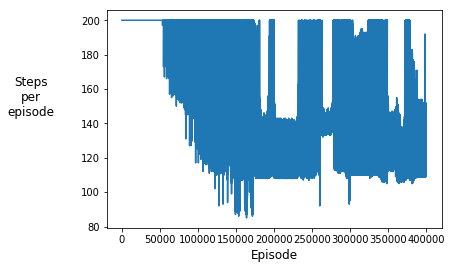

In [3]:
plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=50, fontsize='large')
plt.xlabel('Episode', fontsize='large')
plt.plot(steps_list)

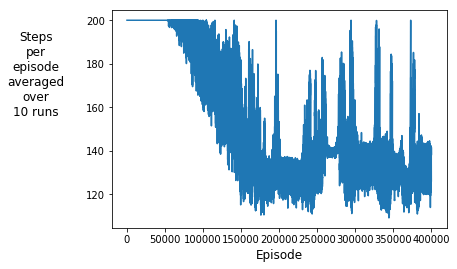

In [4]:
avg_steps = 10
avg_steps_list = get_avg_steps_list(steps_list, avg_steps)
plt.ylabel('Steps\nper\nepisode\naveraged\nover\n{} runs'.format(avg_steps), rotation=0, labelpad=50, fontsize='large')
plt.xlabel('Episode', fontsize='large')
plt.plot(avg_steps_list)

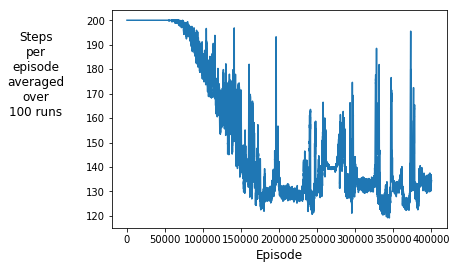

In [5]:
avg_steps = 100
avg_steps_list = get_avg_steps_list(steps_list, avg_steps)
plt.ylabel('Steps\nper\nepisode\naveraged\nover\n{} runs'.format(avg_steps), rotation=0, labelpad=50, fontsize='large')
plt.xlabel('Episode', fontsize='large')
plt.plot(avg_steps_list)

### 2.2. Test

In [6]:
env = gym.make('MountainCar-v0')
total_reward_list = list()
for _ in range(1000):
    total_reward = test(agent, env, learned_policy)
    total_reward_list.append(total_reward)
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


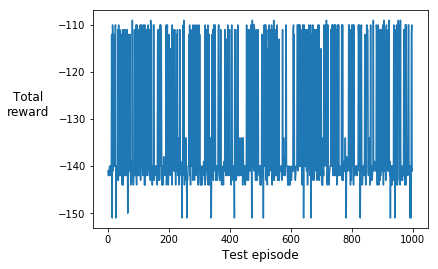

In [7]:
plt.ylabel('Total\nreward', rotation=0, labelpad=30, fontsize='large')
plt.xlabel('Test episode', fontsize='large')
plt.plot(total_reward_list)

In [8]:
max(total_reward_list), min(total_reward_list)

(-109.0, -151.0)